In [28]:
from sqlalchemy import create_engine
import geopandas as gpd

import matplotlib.pyplot as plt
from rasterio.plot import show
import rasterio
from matplotlib.patches import Patch

In [11]:
USER='postgres'
PASSWORD='A123456*'
HOST='localhost'
PORT='5433'
DATABASE='utea'

In [12]:
def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
    )

In [64]:
def generar_plano(shp_prop, path_tif, path_out):
    # Cargar la imagen TIFF con rasterio
    with rasterio.open(path_tif) as src:
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
        img = src.read([1, 2, 3])  # Leer las bandas RGB
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    #show(img, transform=src.transform, ax=ax)
    
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='blue', facecolor=(0, 0, 0, 0), linewidth=1)
    # Agregar etiquetas con lote mas area
    for idx, row in shp_prop.iterrows():
        if row.geom is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geom.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])
    # 🔹 **Agregar Leyenda**
    legend_elements = [
        Patch(facecolor=(0, 0, 0, 0), edgecolor='blue', label='Lotes Aplicados')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

    show(img, transform=src.transform, ax=ax)
    
    # Guardar plano
    fig.savefig(path_out, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

In [41]:
gdf = gpd.read_postgis(
    "SELECT * FROM catastro_iag.catastro WHERE unidad_01=30", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

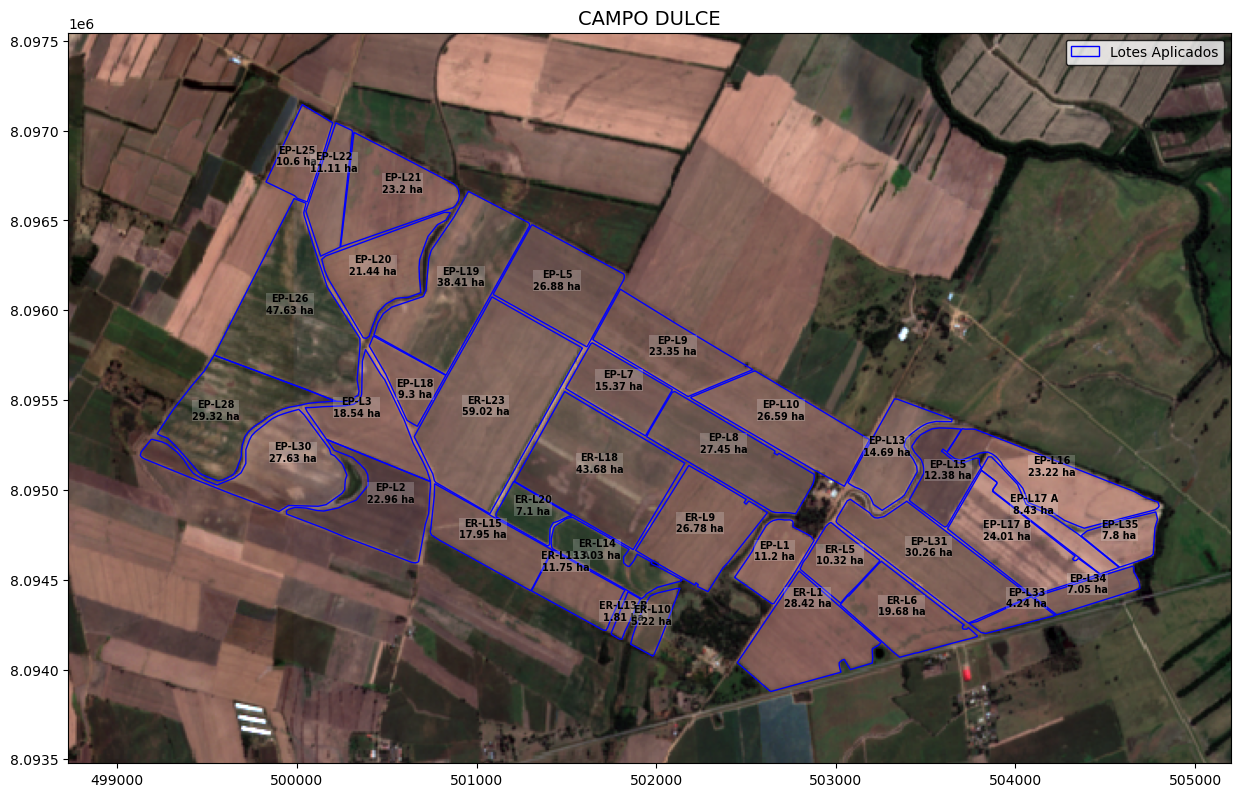

In [65]:
path_plano = "plano_aux_pulverizacion.jpg"
path_tif = r"G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - CATASTRO\RASTER\SENTINEL_2025-07-26_UTM.tif"
#path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2024-01-30_UTM.tif"
generar_plano(gdf, path_tif, path_plano)